In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
m=1.
s=0.5

def get_ml_pars(input_sample):
    input_sample = np.sort(input_sample)
    median = 0
    if np.mod(len(input_sample), 2) == 0:
        median = 0.5* (input_sample[int(len(input_sample)/2 - 1)] + input_sample[int(len(input_sample)/2)])
        
    elif np.mod(len(input_sample), 2) != 0:
        median = input_sample[int((len(input_sample)-1)/2)]
    
    s_hat = np.average( np.abs(input_sample - np.full(input_sample.shape, median)) )
    
    return list((median, s_hat))

In [3]:
get_ml_pars([1,2,2,3,4])

[2, 0.8]

In [4]:
max_sample_size = 500
min_sample_size = 100

ml_pars = np.zeros( shape=(2,len(range(min_sample_size, max_sample_size+1))) )
i = 0
for sample_size in range(min_sample_size, max_sample_size+1):
    
    sample = scipy.stats.laplace.rvs(loc=m, scale=s, size=sample_size)
    ml_pars[:,i] = get_ml_pars(sample)
    
    i += 1

Text(0, 0.5, 'maximum likely m')

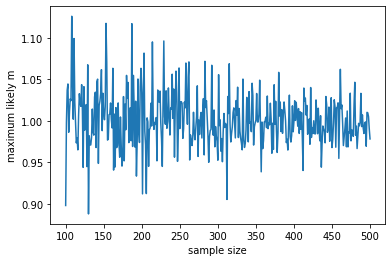

In [5]:
plt.plot(range(min_sample_size, max_sample_size+1), ml_pars[0])
plt.xlabel("sample size")
plt.ylabel("maximum likely m")

Text(0, 0.5, 'maximum likely s')

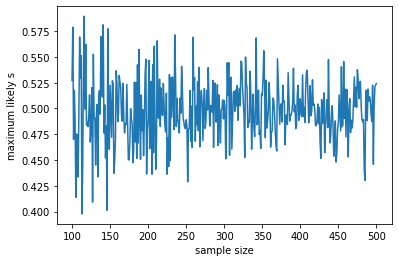

In [6]:
plt.plot(range(min_sample_size, max_sample_size+1), ml_pars[1])
plt.xlabel("sample size")
plt.ylabel("maximum likely s")

In [7]:
ml_df = pd.DataFrame(data=ml_pars.T, columns = ["ML_m", "ML_s"])
ml_df.describe()

,ML_m,ML_s
count,401.000000,401.000000
mean,1.001169,0.498041
std,0.032652,0.030195
min,0.887947,0.397770
25%,0.981016,0.481550
50%,0.997756,0.496693
75%,1.020741,0.518217
max,1.125794,0.589449


In [8]:
ml_big_samples_df = pd.DataFrame(data=ml_pars[:,-100:-1].T, columns = ["ML_m", "ML_s"])
ml_big_samples_df.describe()

,ML_m,ML_s
count,99.000000,99.000000
mean,0.998028,0.496966
std,0.021884,0.023722
min,0.940215,0.430306
25%,0.984263,0.484779
50%,0.996582,0.497253
75%,1.014655,0.512307
max,1.061956,0.547443


In [9]:
"""
ML estimators are getting more accurate and mean is apparently not distorted
but the deviation is still visible in the plot and non vanishing
The trend would infer that it goes towards 0
"""

'\nML estimators are getting more accurate and mean is apparently not distorted\nbut the deviation is still visible in the plot and non vanishing\nThe trend would infer that it goes towards 0\n'

In [15]:
"""Exercise b"""
"""Use analytical expression for Fisher Info to approximate inverse covariance"""

m=1.
s=0.5
sample_size = 500

sample_b = scipy.stats.laplace.rvs(loc=m, scale=s, size=sample_size)
ml_b_pars = get_ml_pars(sample_b)
print("[m,s]: {}".format(ml_b_pars))

def dms_fisher_info(input_sample, m, s):
    central_input_sample = input_sample - np.full(shape=input_sample.shape , fill_value=m)
    fi = (np.sign(central_input_sample)).sum()/(s*s)
    return fi

def dmm_fisher_info(input_sample, m, s):
    return 0.

def dss_fisher_info(input_sample, m, s):
    central_input_sample = input_sample - np.full(shape=input_sample.shape , fill_value=m)
    fi = 2.*(np.abs(central_input_sample)).sum()/(s*s*s)
    fi -= len(input_sample)/(s*s)
    return fi

fisher_info_mat = np.zeros(shape=(2,2))
fisher_info_mat[0,0] = dmm_fisher_info(sample_b, ml_b_pars[0], ml_b_pars[1])
fisher_info_mat[1,1] = dss_fisher_info(sample_b, ml_b_pars[0], ml_b_pars[1])
fisher_info_mat[1,0] = dms_fisher_info(sample_b, ml_b_pars[0], ml_b_pars[1])
fisher_info_mat[1,0] = fisher_info_mat[0,1]

print("fisher info: {}".format(str(fisher_info_mat)))
"""Not able to invert Fisher Info to get variance!"""
"""Wrong version of Fisher Information used, as discussed during the exercise!"""

[m,s]: [1.0006312398886539, 0.5228741175156356]
fisher info: [[   0.            0.        ]
 [   0.         1828.84001336]]


'Wrong version of Fisher Information used, as discussed in the exercise!'

In [16]:
"""The more fundamental fisher info"""
"""Using product of first derivative of log likelyhood function"""

def dmdm_nllhood(input_sample, m, s):
    lhood = 0.
    for point in input_sample:
        lhood += np.sign(point-m)*np.sign(point-m)
    lhood /= s*s
    
    """this function is redundant and returns len(input_sample)/n**2"""
    return lhood

def dsds_nllhood(input_sample, m, s):
    lhood = 0.
    for point in input_sample:
        lhood += (1. - (np.abs(point-m)/s))*(1. - (np.abs(point-m)/s))
    lhood /= s*s
    
    return lhood

def dmds_nllhood(input_sample, m, s):
    lhood = 0.
    for point in input_sample:
        dm_lhood = np.sign(point-m)
        ds_lhood = 1. - (np.abs(point-m)/s)
        lhood += dm_lhood*ds_lhood
    dm_lhood /= s*s
    
    return lhood

inv_cov_mat = np.zeros(shape=(2,2))
inv_cov_mat[0,0] = dmdm_nllhood(sample_b, ml_b_pars[0], ml_b_pars[1])
inv_cov_mat[1,1] = dsds_nllhood(sample_b, ml_b_pars[0], ml_b_pars[1])
inv_cov_mat[1,0] = dmds_nllhood(sample_b, ml_b_pars[0], ml_b_pars[1])
inv_cov_mat[0,1] = inv_cov_mat[1,0]

print("inverse covariance matrix estimate")
print(inv_cov_mat)
cov_mat = np.linalg.inv(inv_cov_mat)
print("covariance matrix estimate")
print(cov_mat)

inverse covariance matrix estimate
[[1.82884001e+03 1.09903400e+00]
 [1.09903400e+00 1.79179209e+03]]
covariance matrix estimate
[[ 5.46794887e-04 -3.35388338e-07]
 [-3.35388338e-07  5.58100671e-04]]
